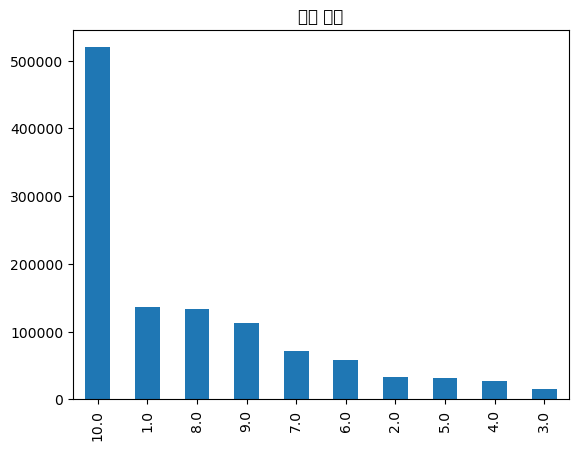

단어 집합의 크기 : 44521
최대 길이 이하인 샘플의 비율 : 88.91449841209918


In [1]:
# 전처리 과정
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 경고 무시
warnings.filterwarnings(action='ignore')

# 데이터 불러오기
df1 = pd.read_csv('../data/review-rating1.csv')
df2 = pd.read_csv('../data/review-rating2.csv')
df3 = pd.read_csv('../data/review-rating3.csv')
df4 = pd.read_csv('../data/review-rating4.csv')
df = pd.concat([df1, df2, df3, df4])

# 중복값 제거
df.drop_duplicates(inplace=True)
len(df)

# 평점 분포 그래프 출력
df['실제평점'].value_counts().plot(kind = 'bar')
plt.title('평점 분포')
plt.show()

# 특수문자,기호 제거
df['리뷰'] = df['리뷰'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]","")

# 공백 제거
df['리뷰'] = df['리뷰'].str.replace('^ +', "")
df['리뷰'].replace('', np.nan, inplace=True)

# null 샘플 제거
df = df.dropna(how = 'any')

# 불용어 사전
# stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
with open("c:/data/movie_list/불용어사전.txt") as f:
    lines = f.read().splitlines()
stopwords = []
for line in lines:
    stopwords.append(line.split("\t")[0])

# 데이터를 X, Y로 나누고 학습용, 검증용으로 나누기
y = df['실제평점']
X = df['리뷰']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# 형태소 분석
okt = Okt()
X_train_lis = []
X_test_lis = []
for sentence in X_train:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train_lis.append(temp_X)
for sentence in X_test:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test_lis.append(temp_X)

# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_lis)
# print(tokenizer.word_index) 

# 출현빈도가 3회 미만인 단어들
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어수
rare_cnt = 0
total_freq = 0
rare_freq = 0
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
# print(total_cnt) #단어집합 크기
# print(rare_cnt) #희귀단어수

# 단어 집합의 크기
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :', vocab_size)

# 텍스트를 숫자 시퀀스로 변환
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train_lis) 
X_train = tokenizer.texts_to_sequences(X_train_lis)
X_test = tokenizer.texts_to_sequences(X_test_lis)

# 종속변수를 array로 변환
y_train = np.array(y_train)
y_test = np.array(y_test)

# 리뷰의 최대 길이
max_len=max(len(l) for l in X_train)

#최대 길이 이하인 샘플의 비율
cnt = 0
for s in X_train:
    if(len(s) <= 30):
        cnt = cnt + 1
print("최대 길이 이하인 샘플의 비율 :", (cnt / len(X_train))*100)

# 독립변수 패딩
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
# 하이퍼파라미터 튜닝
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 모델 생성하는 함수
def create_model(optimizer="rmsprop"):
    model = Sequential()
    model.add(Embedding(vocab_size, 100))
    model.add(LSTM(128))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

# 모델 생성
neural_network = KerasClassifier(model=create_model, verbose=0)

# 하이퍼파라미터 탐색 영역을 정의
pipe=Pipeline([
    ('clf', neural_network)
    ])
params={
    'clf__epochs': [10, 15],
    'clf__batch_size': [32,64,128],
    'clf__optimizer': ["rmsprop", "adam"],
    }

# 파라미터 검색
grid=GridSearchCV(pipe, params, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(X_train, y_train)

# 결과 출력
print(grid_result.best_params_)
print(grid_result.best_score_)

In [2]:
# 최적의 파라미터로 모델 마무리
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 모델 생성
model = Sequential()
model.add(Embedding(vocab_size, 250))
model.add(LSTM(256))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])
model.summary()

# 모델 학습
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
mc = ModelCheckpoint('../model/review_RNN.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
hist = model.fit(X_train, y_train, batch_size = 32, epochs=10, validation_split=0.2, callbacks=[es, mc])

# 모델 평가
loaded_model = load_model('../model/review_RNN.h5')
loaded_model.evaluate(X_test, y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 250)         11143500  
                                                                 
 lstm (LSTM)                 (None, 256)               519168    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 11,662,925
Trainable params: 11,662,925
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
22647/22648 [============================>.] - ETA: 0s - loss: 5.1464 - mse: 5.1464
Epoch 1: val_loss improved from inf to 4.77402, saving model to ../model\review_RNN.h5
22648/22648 [==============================] - 1255s 55ms/step - loss: 5.1464 - mse: 5.1464 - val_loss: 4.7740 - val_mse: 4.77

[4.538585186004639, 4.538585186004639]

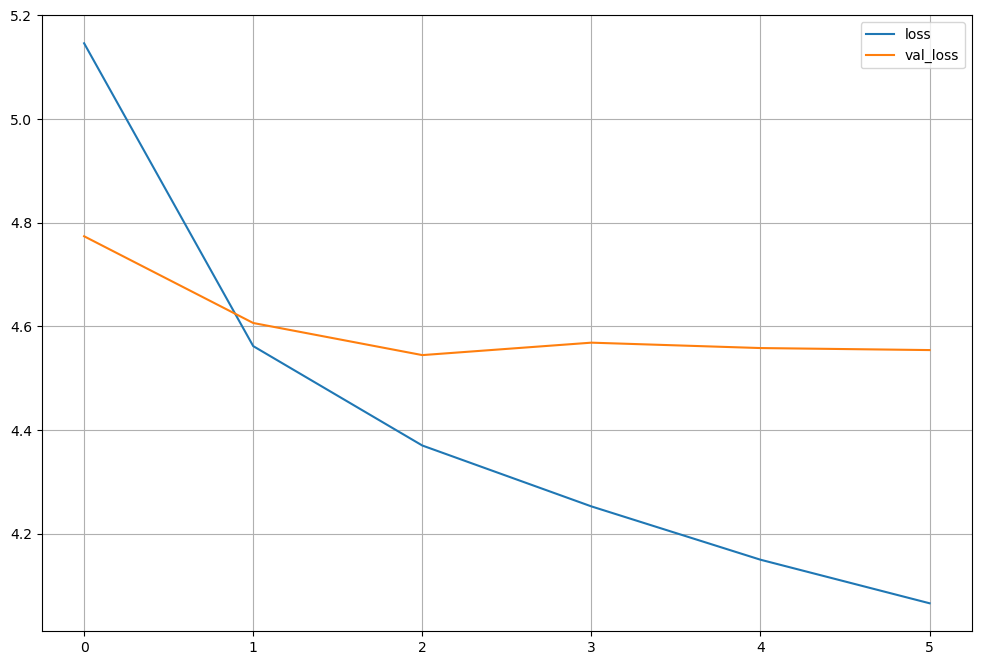

In [3]:
# 모델 학습 과정 표시
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss']) #손실
plt.plot(hist.history['val_loss']) #validation 손실
plt.legend(['loss','val_loss'])
plt.grid()
plt.show()

In [5]:
# 드롭아웃 추가
from keras.layers import Embedding, Dense, LSTM, Dropout
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 모델 생성
model = Sequential()
model.add(Embedding(vocab_size, 250))
model.add(LSTM(256))
model.add(Dropout(0.2))  # 드롭아웃을 통한 모델 복잡도 조절
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])
model.summary()

# 모델 학습
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
mc = ModelCheckpoint('../model/review_RNN.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
hist = model.fit(X_train, y_train, batch_size = 32, epochs=10, validation_split=0.2, callbacks=[es, mc])

# 모델 평가
loaded_model = load_model('../model/review_RNN.h5')
loaded_model.evaluate(X_test, y_test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 250)         11143500  
                                                                 
 lstm_2 (LSTM)               (None, 256)               519168    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11,679,181
Trainable params: 11,679,181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
22648/22648 [==================

[4.4609503746032715, 4.4609503746032715]

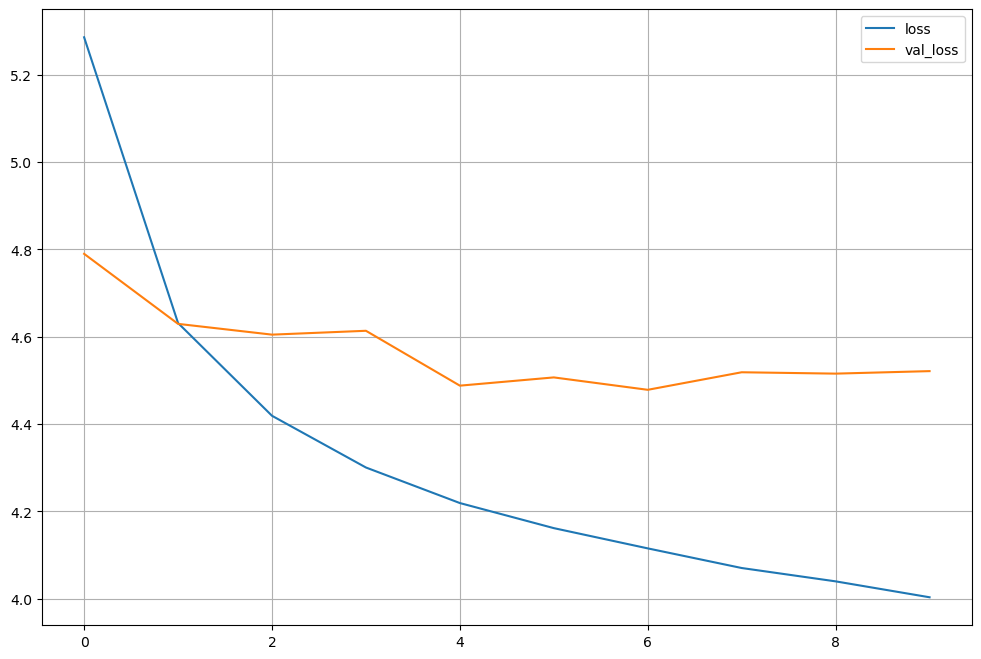

In [6]:
# 모델 학습 과정 표시
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss']) #손실
plt.plot(hist.history['val_loss']) #validation 손실
plt.legend(['loss','val_loss'])
plt.grid()
plt.show()

In [7]:
# 정규화 추가
from keras.layers import Embedding, Dense, LSTM
from keras import regularizers
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 모델 생성
model = Sequential()
model.add(Embedding(vocab_size, 250))
model.add(LSTM(256))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])
model.summary()

# 모델 학습
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
mc = ModelCheckpoint('../model/review_RNN.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
hist = model.fit(X_train, y_train, batch_size = 32, epochs=10, validation_split=0.2, callbacks=[es, mc])

# 모델 평가
loaded_model = load_model('../model/review_RNN.h5')
loaded_model.evaluate(X_test, y_test)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 250)         11143500  
                                                                 
 lstm_3 (LSTM)               (None, 256)               519168    
                                                                 
 dense_5 (Dense)             (None, 64)                16448     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11,679,181
Trainable params: 11,679,181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
22647/22648 [============================>.] - ETA: 0s - loss: 5.2027 - mse: 5.1525
Epoch 1: val_loss improved from inf to 4.82991, saving model to ../model\review

[4.517889499664307, 4.484938621520996]

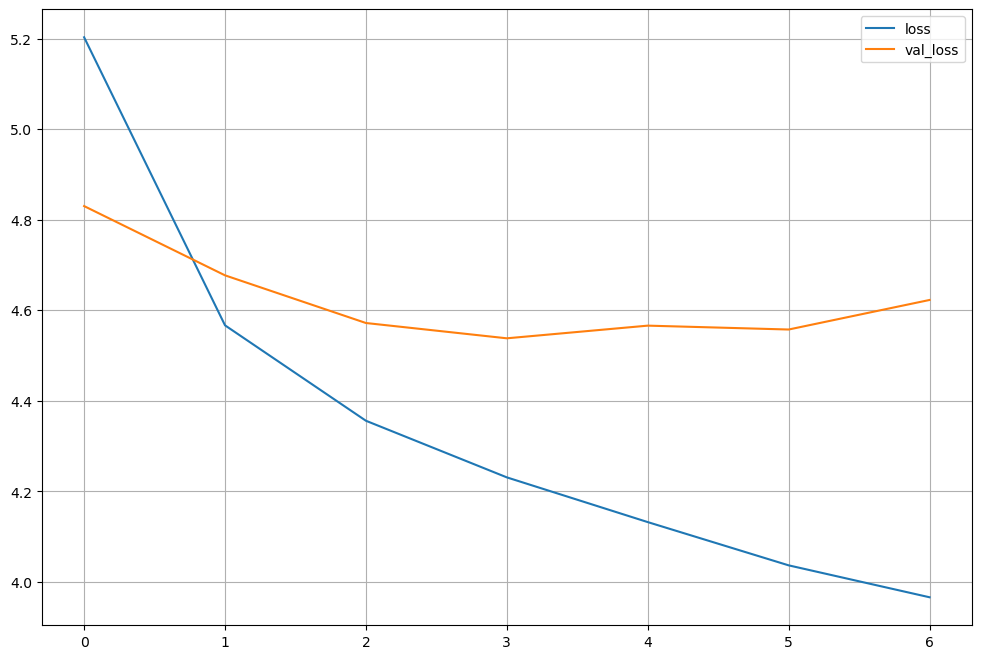

In [8]:
# 모델 학습 과정 표시
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss']) #손실
plt.plot(hist.history['val_loss']) #validation 손실
plt.legend(['loss','val_loss'])
plt.grid()
plt.show()

In [9]:
# 드롭아웃, 정규화 추가
from keras.layers import Embedding, Dense, LSTM, Dropout
from keras import regularizers
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 모델 생성
model = Sequential()
model.add(Embedding(vocab_size, 250))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])
model.summary()

# 모델 학습
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
mc = ModelCheckpoint('../model/review_RNN.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
hist = model.fit(X_train, y_train, batch_size = 32, epochs=10, validation_split=0.2, callbacks=[es, mc])

# 모델 평가
loaded_model = load_model('../model/review_RNN.h5')
loaded_model.evaluate(X_test, y_test)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 250)         11143500  
                                                                 
 lstm_4 (LSTM)               (None, 256)               519168    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11,679,181
Trainable params: 11,679,181


[4.478996753692627, 4.413059711456299]

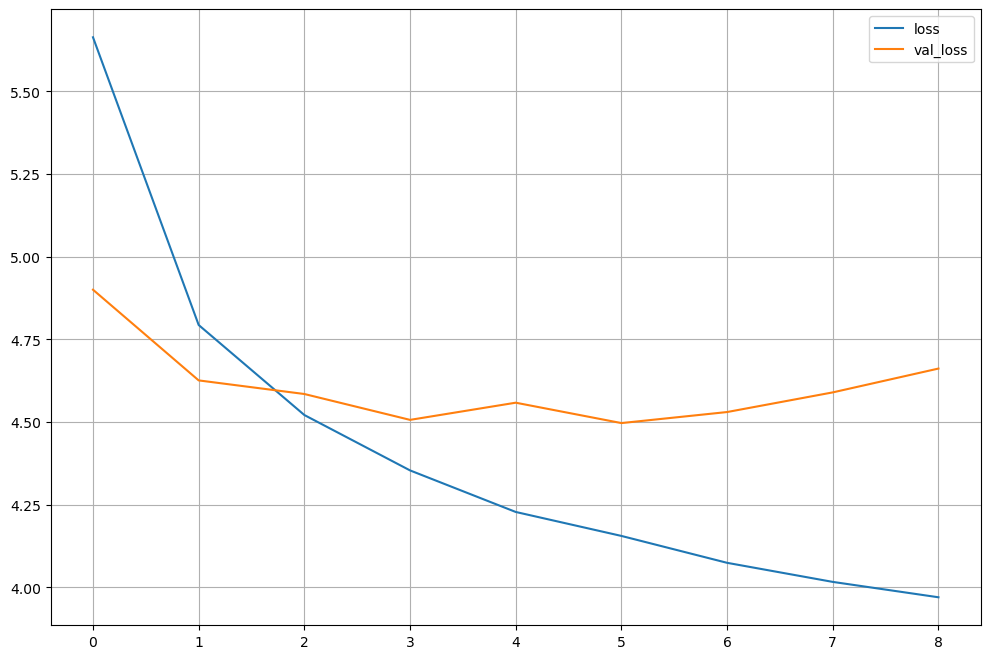

In [10]:
# 모델 학습 과정 표시
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss']) #손실
plt.plot(hist.history['val_loss']) #validation 손실
plt.legend(['loss','val_loss'])
plt.grid()
plt.show()

In [11]:
# 드롭아웃 추가
from keras.layers import Embedding, Dense, LSTM, Dropout
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 모델 생성
model = Sequential()
model.add(Embedding(vocab_size, 250))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])
model.summary()

# 모델 학습
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
mc = ModelCheckpoint('../model/review_RNN.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
hist = model.fit(X_train, y_train, batch_size = 32, epochs=10, validation_split=0.2, callbacks=[es, mc])

# 모델 평가
loaded_model = load_model('../model/review_RNN.h5')
loaded_model.evaluate(X_test, y_test)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 250)         11143500  
                                                                 
 lstm_5 (LSTM)               (None, 256)               519168    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 11,662,925
Trainable params: 11,662,925
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
22647/22648 [============================>.] - ETA: 0s - loss: 5.2924 - mse: 5.2924
Epoch 1: val_loss improved from inf to 4.79028, saving model to ../model\review

[4.484431266784668, 4.484431266784668]

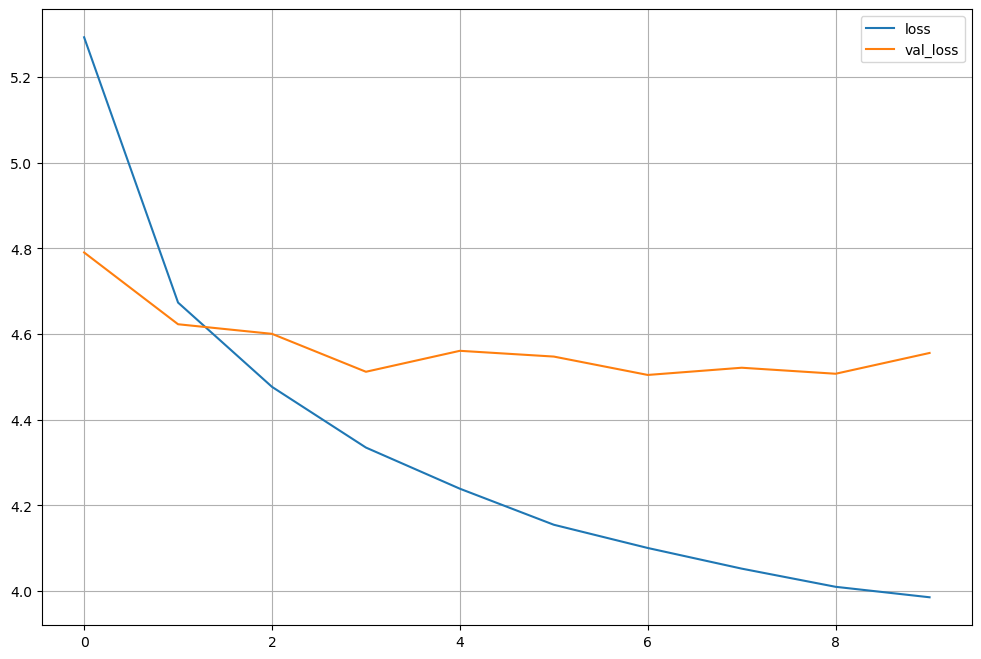

In [12]:
# 모델 학습 과정 표시
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss']) #손실
plt.plot(hist.history['val_loss']) #validation 손실
plt.legend(['loss','val_loss'])
plt.grid()
plt.show()

In [13]:
# 드롭아웃 추가
from keras.layers import Embedding, Dense, LSTM, Dropout
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 모델 생성
model = Sequential()
model.add(Embedding(vocab_size, 250))
model.add(LSTM(256))
model.add(Dropout(0.2))  # 드롭아웃을 통한 모델 복잡도 조절
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))  # 드롭아웃을 통한 모델 복잡도 조절
model.add(Dense(1, activation='linear'))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])
model.summary()

# 모델 학습
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
mc = ModelCheckpoint('../model/review_RNN.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
hist = model.fit(X_train, y_train, batch_size = 32, epochs=10, validation_split=0.2, callbacks=[es, mc])

# 모델 평가
loaded_model = load_model('../model/review_RNN.h5')
loaded_model.evaluate(X_test, y_test)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 250)         11143500  
                                                                 
 lstm_6 (LSTM)               (None, 256)               519168    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 11,695,693
Trainable params: 11,695,693


[4.489142894744873, 4.489142894744873]

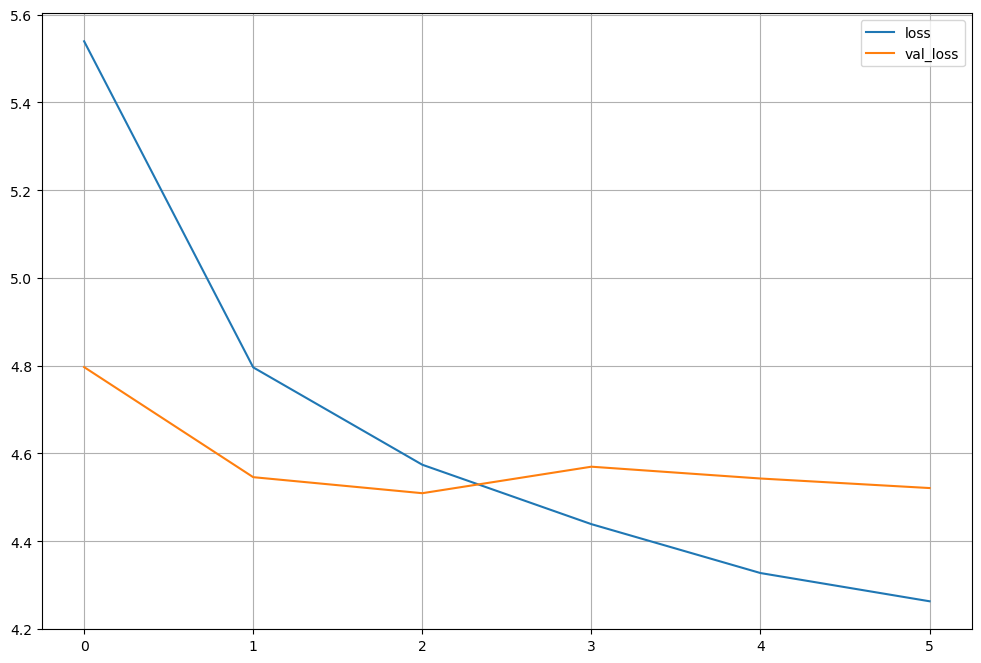

In [14]:
# 모델 학습 과정 표시
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss']) #손실
plt.plot(hist.history['val_loss']) #validation 손실
plt.legend(['loss','val_loss'])
plt.grid()
plt.show()

In [15]:
# 드롭아웃, 정규화 추가
from keras.layers import Embedding, Dense, LSTM, Dropout
from keras import regularizers
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 모델 생성
model = Sequential()
model.add(Embedding(vocab_size, 250))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])
model.summary()

# 모델 학습
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
mc = ModelCheckpoint('../model/review_RNN.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
hist = model.fit(X_train, y_train, batch_size = 32, epochs=10, validation_split=0.2, callbacks=[es, mc])

# 모델 평가
loaded_model = load_model('../model/review_RNN.h5')
loaded_model.evaluate(X_test, y_test)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 250)         11143500  
                                                                 
 lstm_7 (LSTM)               (None, 256)               519168    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)               

[4.48302698135376, 4.392374515533447]

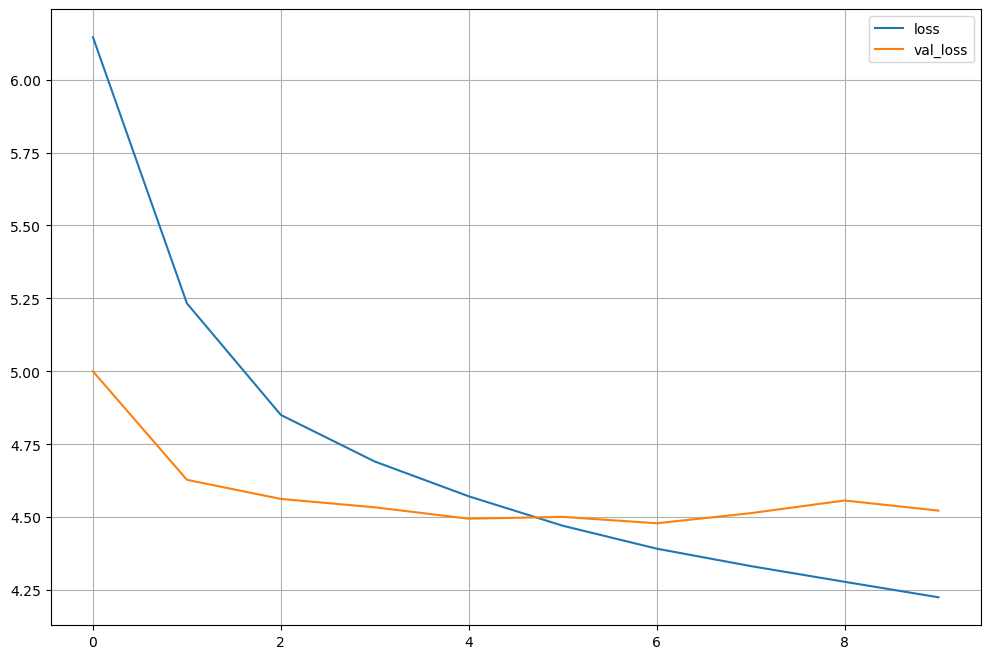

In [16]:
# 모델 학습 과정 표시
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss']) #손실
plt.plot(hist.history['val_loss']) #validation 손실
plt.legend(['loss','val_loss'])
plt.grid()
plt.show()

In [ ]:
# 하이퍼파라미터 튜닝
from keras.layers import Embedding, Dense, LSTM, Dropout
from keras import regularizers
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential

# 모델 생성하는 함수
def create_model(embedding_dim=250, units=256, dense1_units=128, dense2_units=64):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim))
    model.add(LSTM(units=units))
    model.add(Dropout(0.2))
    model.add(Dense(units=dense1_units, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(units=dense2_units, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer="rmsprop", loss='mse', metrics=['mse'])
    return model

# 모델 생성
model = KerasRegressor(build_fn=create_model, verbose=0)

# 하이퍼파라미터 탐색 영역을 정의
param_grid={
    'epochs': [10],
    'batch_size': [32, 64, 128],
    'embedding_dim': [100, 150, 200, 250, 300],
    'units': [64, 128, 256, 512],
    'dense1_units': [32, 64, 128, 256],
    'dense2_units': [16, 32, 64, 128],
}

# 파라미터 검색
grid=GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
# 모델 학습
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
mc = ModelCheckpoint('../model/review_RNN_search.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
grid_result = grid.fit(X_train, y_train, validation_split=0.2, callbacks=[es, mc])

# 결과 출력
print(grid_result.best_params_)
print(grid_result.best_score_)

In [11]:
# 드롭아웃, 정규화 추가
from keras.layers import Embedding, Dense, LSTM, Dropout
from keras import regularizers
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 모델 생성
model = Sequential()
model.add(Embedding(vocab_size, 250))
model.add(LSTM(1024))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])
model.summary()

# 모델 학습
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
mc = ModelCheckpoint('../model/review_RNN.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
hist = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2, callbacks=[es, mc])

# 모델 평가
loaded_model = load_model('../model/review_RNN.h5')
loaded_model.evaluate(X_test, y_test)

Model: "sequential_2910"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2910 (Embedding)  (None, None, 250)         11130250  
                                                                 
 lstm_2910 (LSTM)            (None, 1024)              5222400   
                                                                 
 dropout_87 (Dropout)        (None, 1024)              0         
                                                                 
 dense_87 (Dense)            (None, 512)               524800    
                                                                 
 dropout_88 (Dropout)        (None, 512)               0         
                                                                 
 dense_88 (Dense)            (None, 128)               65664     
                                                                 
 dropout_89 (Dropout)        (None, 128)           

In [ ]:
# 앙상블 기법
from keras.layers import Embedding, Dense, LSTM, Dropout
from keras import regularizers
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.ensemble import VotingRegressor

# 여러 모델 생성
model1 = Sequential()
model1.add(Embedding(vocab_size, 250))
model1.add(LSTM(128))
model1.add(Dropout(0.2))
model1.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(Dropout(0.3))
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(1, activation='linear'))
model1.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])
model1.summary()

model2 = Sequential()
model2.add(Embedding(vocab_size, 250))
model2.add(LSTM(256))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dropout(0.3))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(1, activation='linear'))
model2.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])
model2.summary()

model3 = Sequential()
model3.add(Embedding(vocab_size, 250))
model3.add(LSTM(512))
model3.add(Dropout(0.2))
model3.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model3.add(Dropout(0.3))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(1, activation='linear'))
model3.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])
model3.summary()

# 앙상블 모델 생성
ensemble_model = VotingRegressor(estimators=[('model1', model1), ('model2', model2), ('model3', model3)])

# 모델 학습
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
mc = ModelCheckpoint('../model/review_RNN.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
hist = ensemble_model.fit(X_train, y_train, batch_size = 32, epochs=10, validation_split=0.2, callbacks=[es, mc])

# 모델 평가
loaded_model = load_model('../model/review_RNN.h5')
loaded_model.evaluate(X_test, y_test)

In [ ]:
# 모델 학습 과정 표시
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss']) #손실
plt.plot(hist.history['val_loss']) #validation 손실
plt.legend(['loss','val_loss'])
plt.grid()
plt.show()